# Kernel VAMP / kernel CCA

This notebook illustrates how to use kernel canonical correlation analysis (kernel CCA) <cite data-cite="nbkcca-bach2002kernel">(Bach, 2002)</cite> to compute coherent sets.

CCA <cite data-cite="nbkcca-hotelling1992relations">(Hotelling, 1992)</cite> was originally developed to maximize the correlation between two multidimensional random variables $X$ and $Y$. Kernel CCA is a nonlinear variant of CCA, where the standard inner products are replaced by a kernel function $k$ (using the well-known *kernel trick*). Popular kernel functions are the polynomial kernel $k(x, x^\prime) = (c + x^\top x^\prime)^p$ and the Gaussian kernel $k(x, x^\prime) = \exp(-\|x-x^\prime\|_2^2/2\sigma^2)$, see also [deeptime.kernels](../api/index_kernels.rst). In our setting, $Y$ is a time-lagged version of $X$, i.e., we consider the process $Y_t = X_{t + \tau}$. Here, $\tau$ is a fixed lag time. The kernel CCA problem <cite data-cite="nbkcca-bach2002kernel">(Bach, 2002)</cite> can be written as an optimization problem of the form
$$
    \sup_{\substack{ f \in \mathbb{H}_X \\ g \in \mathbb{H}_Y }} \langle g, C_{YX} f \rangle_{\mathbb{H}_y} \quad \text{s.t.} \quad
    \begin{cases}
    \langle f, C_{XX} f\rangle_{\mathbb{H}_X} = 1, \\
    \langle g, C_{YY} g\rangle_{\mathbb{H}_Y} = 1,
    \end{cases}
$$
where $C_{XX}$ and $C_{YY}$ are covariance operators associated with $X$ and $Y$, respectively, and $C_{YX}$ is the cross-covariance operator (these operators can be regarded as nonlinear versions of covariance and cross-covariance matrices). The solution of this optimization problem is given by the solution of a generalized eigenvalue problem, which can be simplified to
$$
    \big(C_{XX} + \varepsilon \mathcal{I}\big)^{-1} C_{XY} \big(C_{YY} + \varepsilon \mathcal{I}\big)^{-1} C_{YX} f = \rho^2 f.
$$
Since the covariance operators are in general not invertible, we regularized the problem: $\varepsilon$ is a regularization parameter and $\mathcal{I}$ the identity operator. We estimate these operators using training data $\{x_i\}_{i=1}^n$ and $\{y_i\}_{i=1}^n$, where $y_i$ is the time-lagged version of $x_i$. Eigenfunctions of this operator eigenvalue problem can be found by solving an auxiliary matrix eigenvalue problem: Let $G_{XX}$ and $G_{YY}$ denote the Gram matrices with entries $[G_{XX}]_{ij} = k(x_i, x_j)$ and $[G_{YY}]_{ij} = k(y_i, y_j)$ and $I$ the identity matrix. We solve
$$
  (G_{XX} + n \varepsilon I)^{-1} G_{XX} G_{YY} (G_{YY} + n \varepsilon I)^{-1} v = \rho^2 v
$$
and obtain eigenfunctions $f = \Phi v$, where $\Phi = [k(x_1, \cdot), \dots, k(x_n, \cdot)]$ is the feature matrix associated with $X$. There are many equivalent formulations, a detailed derivation can be found in <cite data-cite="nbkcca-klus2019coherent">(Klus, 2019)</cite>.

Kernel CCA applied to Lagrangian data computes eigenfunctions of a dynamical operator associated with the forward-backward dynamics, which can be interpreted in terms of coherent sets as defined, e.g., in <cite data-cite="nbkcca-froyland2010coherent">(Froyland, 2010)</cite>. We will use the Bickley jet as a guiding example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime as dt

from IPython.display import HTML

First, we uniformly sample $n$ data points in $\mathbb{X} = [0, 20] \times [-3, 3]$. The domain is periodic in x-direction. The lag-time is defined to be $\tau = 40$.

In [2]:
n = 3000
bickleyData = dt.data.bickley_jet(n_particles=n, n_jobs=8)
dataset = bickleyData.endpoints_dataset()

We choose the Gaussian kernel with bandwidth $\sigma = 1$. Note that this kernel does not take the periodicity into account. However, the kernel could be easily adapted to be periodic in x-direction.

In [3]:
sigma = 1
kernel = dt.kernels.GaussianKernel(sigma)

We then compute the first nine dominant eigenvalues and corresponding eigenvectors. The regularization parameter is set to $\epsilon = 10^{-3}$.

In [4]:
kcca_estimator = dt.decomposition.KernelCCA(kernel, n_eigs=9, epsilon=1e-3)
kcca_model = kcca_estimator.fit((dataset.data, dataset.data_lagged)).fetch_model()
ev_real = np.real(kcca_model.eigenvectors)

Let us visualize a few dominant eigenfunctions.

Text(0.5, 1.0, '6th eigenfunction')

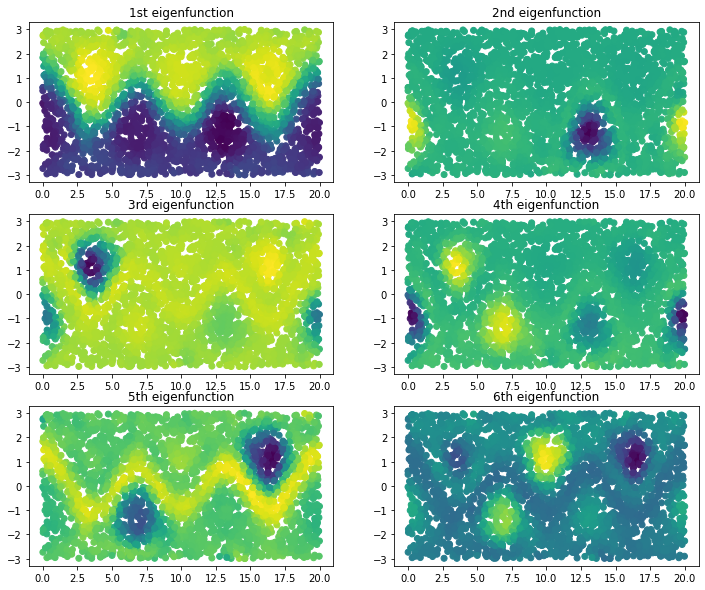

In [5]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(ncols=2, nrows=3)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(*dataset.data.T, c=ev_real[:, 0])
ax.set_title('1st eigenfunction')

ax = fig.add_subplot(gs[0, 1])
ax.scatter(*dataset.data.T, c=ev_real[:, 1])
ax.set_title('2nd eigenfunction')

ax = fig.add_subplot(gs[1, 0])
ax.scatter(*dataset.data.T, c=ev_real[:, 2])
ax.set_title('3rd eigenfunction')

ax = fig.add_subplot(gs[1, 1])
ax.scatter(*dataset.data.T, c=ev_real[:, 3])
ax.set_title('4th eigenfunction')

ax = fig.add_subplot(gs[2, 0])
ax.scatter(*dataset.data.T, c=ev_real[:, 4])
ax.set_title('5th eigenfunction')

ax = fig.add_subplot(gs[2, 1])
ax.scatter(*dataset.data.T, c=ev_real[:, 5])
ax.set_title('6th eigenfunction')

The first eigenfunction distinguishes between the top and bottom half of the domain. The other eigenfunctions pick up combinations of the vortices.

In order to find the corresponding coherent sets, we cluster the eigenvectors using $k$-means. Here, we compute 9 clusters.

In [6]:
kmeans = dt.clustering.Kmeans(n_clusters=9, n_jobs=8).fit(ev_real).fetch_model()

Clustering of the dominant eigenfunctions results in the expected coherent sets.

Text(0.5, 1.0, 'Clustering of the eigenfunctions')

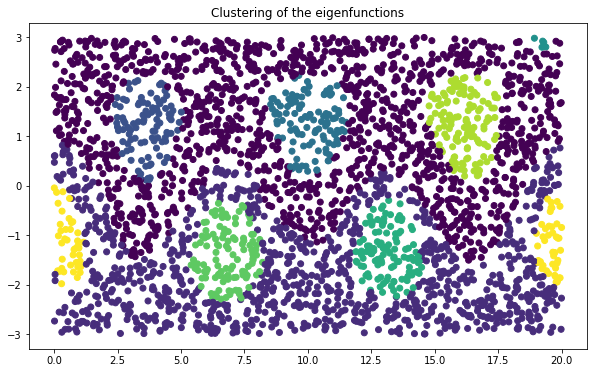

In [7]:
plt.figure(figsize=(10, 6))
c = kmeans.transform(ev_real)
plt.scatter(*dataset.data.T, c=c)
plt.title('Clustering of the eigenfunctions')

In [8]:
ani = bickleyData.make_animation(s=100, c=c/9, stride=2)
HTML(ani.to_html5_video())